In [5]:
import sqlite3
import pandas as pd
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import numpy.polynomial.polynomial as poly

import statsmodels.nonparametric.smoothers_lowess as lw

plt.style.use('ggplot')
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['ytick.major.pad'] = 8

# Preliminary Analysis
The following is a compilation of the analysis done before collecting our experimental data. 

## Trial Duration
Let's look at trial duration using the 0.99 qunatile as a cutoff to account for turkers leaving their computer, stalled connections etc.

In [6]:
df = pd.read_csv("july1.csv")

In [7]:

q = 0.98
cutoff = df['TrialDuration'].quantile(q)
df = df[df['TrialDuration'] <= cutoff]
tmp = df[df['Reasoning'] == '(None)']


Here we'll plot each turker's trial duration over time. (Trials 9, 18, and 27 are filtered our because these are trials which users submit rationals for their answers and thus have longer trial durations)


<IPython.core.display.Javascript object>


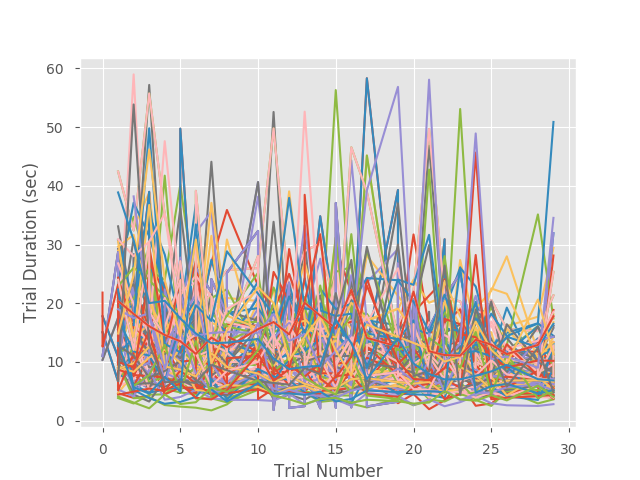

In [9]:
# Filter out the trials with reasoning prompts.
tmp = df[df['Reasoning'] == '(None)']

groups = tmp.groupby('SessionId')
for i, ng in enumerate(groups):
    name, group = ng
    group = group.sort_values('TrialOrderNumber')
    # Exclude the first trial.
    plt.plot(group['TrialOrderNumber'][1:],group['TrialDuration'][1:])
plt.xlabel('Trial Number')
plt.ylabel('Trial Duration (sec)')


Looks like there might be some pattern here, but it's a little difficult to make-out. Let's take a look at the averages

<IPython.core.display.Javascript object>


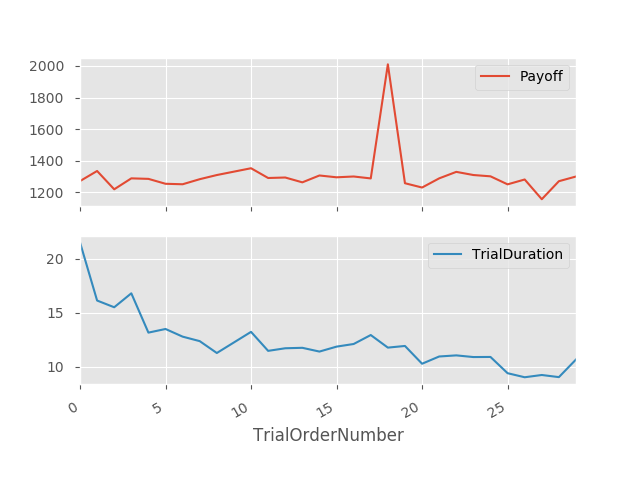

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1207e4b10>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x120e53cd0>], dtype=object)

In [16]:
plt.close()

# Plot the averages
average = tmp[['Payoff', 'TrialDuration', 'TrialOrderNumber']].groupby('TrialOrderNumber').mean()
average.plot(subplots=True)


Seems like trial duration is going down over time which means turkers are learning how to use the display faster.

### Trial Payoff

Let's take a look at each turker's payoffs at each time point:

<IPython.core.display.Javascript object>


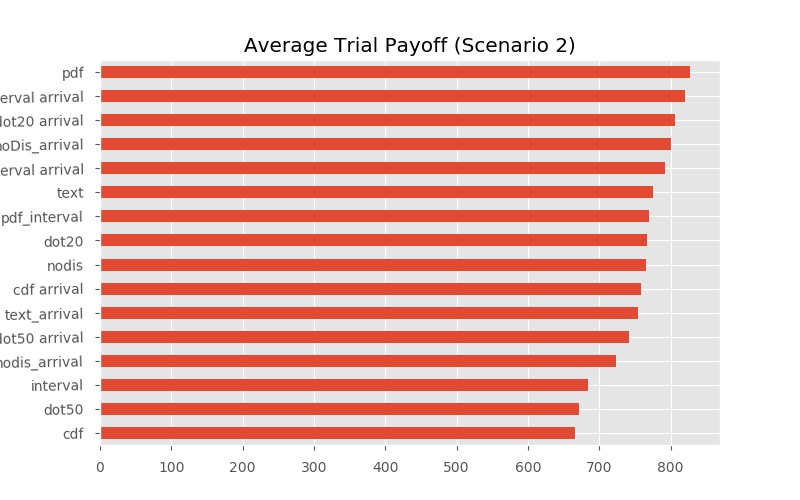

<IPython.core.display.Javascript object>


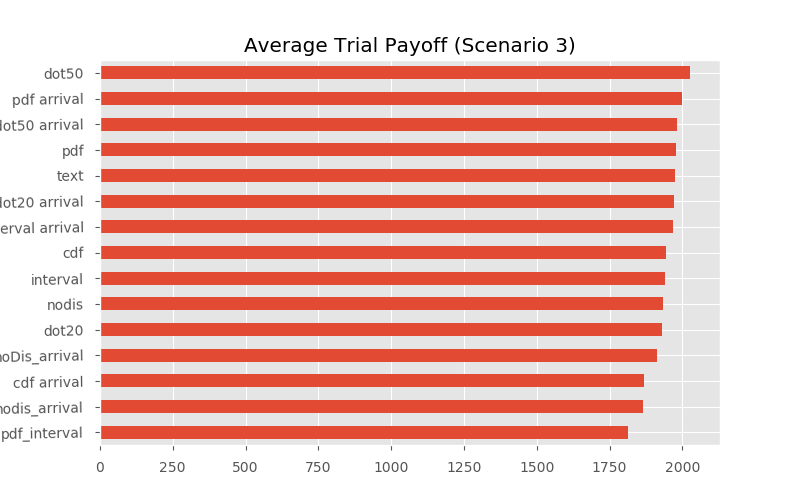

In [11]:
s = df.groupby('ScenarioId')
for n, g in s:
    plt.figure(int(n), figsize=(8, 5))
    g.groupby('ConditionId').mean()['Payoff'].sort_values().plot(kind='barh', title='Average Trial Payoff (Scenario {})'.format(n), rot=1)


Appears that there could be some trends here, dot50 seems to appear in the top half of all three scenarios. 
We can't tell for cetain because some of the conditions only have less than 3 subjects each.

<IPython.core.display.Javascript object>


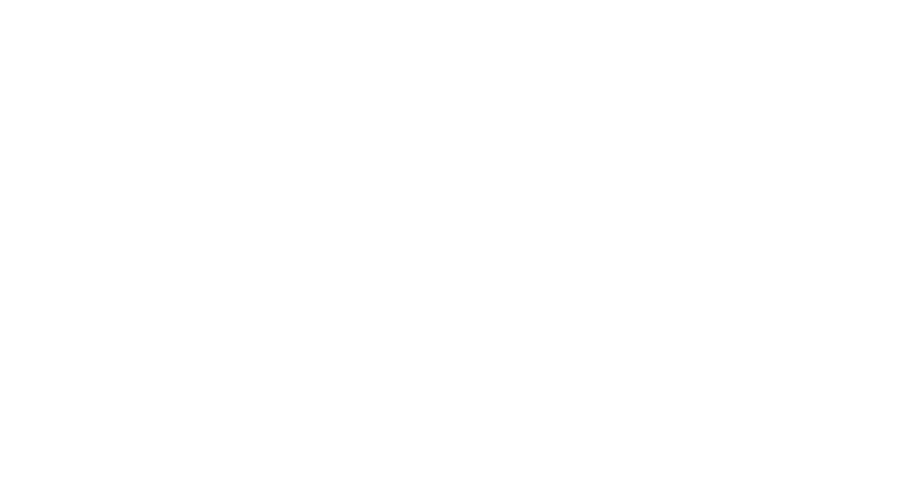

<IPython.core.display.Javascript object>


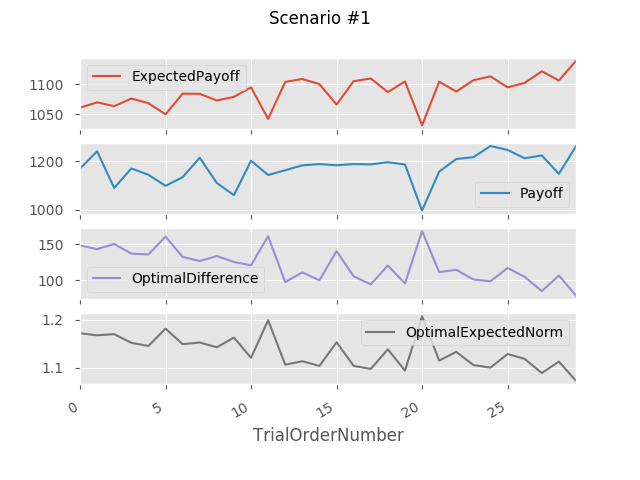

<IPython.core.display.Javascript object>


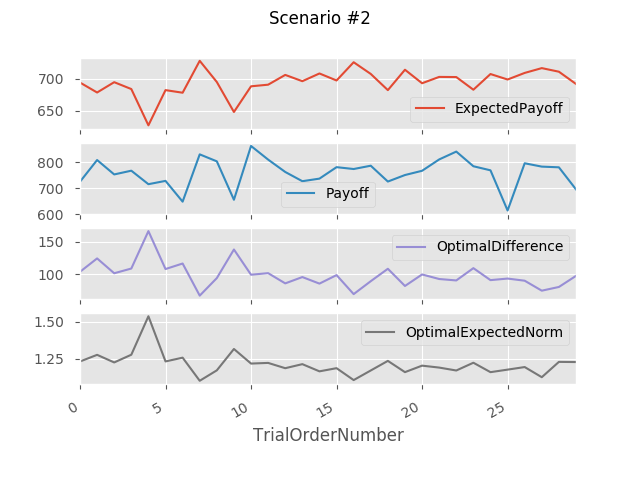

<IPython.core.display.Javascript object>


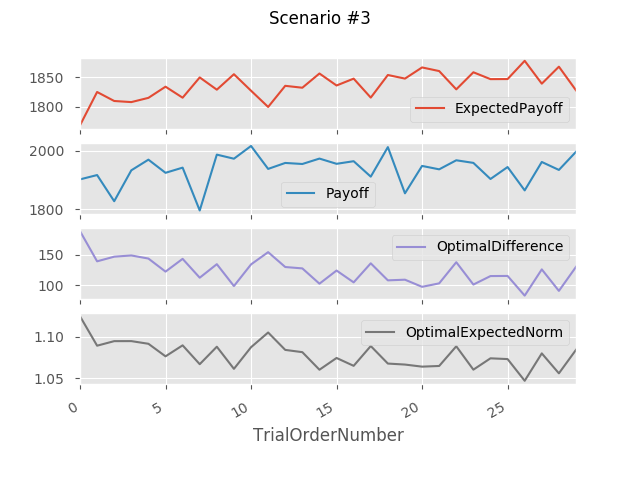

In [20]:
df = df[df['ScenarioId'] != 4]
scenarios = df.groupby('ScenarioId')

for indexi, c in enumerate(scenarios, 1):
    scenario_name, scenario_df = c
    fig = plt.figure(indexi, figsize=(9, 5))
    cd = scenario_df[['TrialOrderNumber', "ExpectedPayoff", "Payoff", "OptimalDifference", "OptimalExpectedNorm"]].groupby('TrialOrderNumber').mean()
    p = cd.plot(subplots=True, title="Scenario #{}".format(scenario_name))

## Experiment length

The first pilots of our experiment was carried out with 30 trials. To esablish the length necessary to investigate possible learning curves that may be occuring, we conducted an additonal pilot with a trial length of 60.

Lets load the data and plot how the norm response changes over each trial. 

Learning curves in begin steep, but level off around 20. It looks like 40 trials will be an adequate length to demostrate learning for the purpose this experiment.

<IPython.core.display.Javascript object>


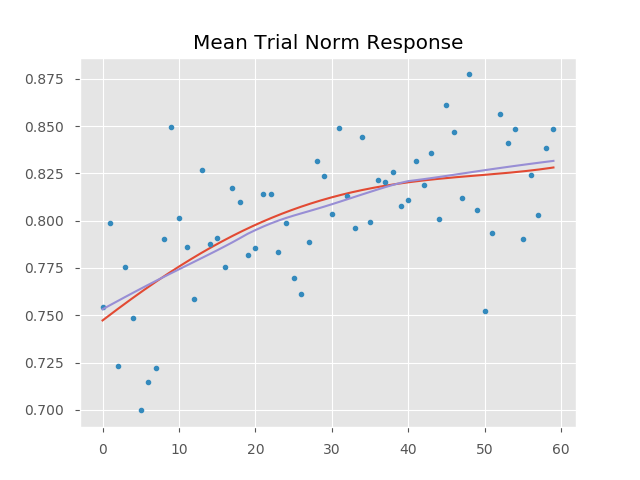

In [21]:
# Load the data
df_july20 = pd.read_csv("July_20_mturk.csv") 
df_july20['Norm'] = df_july20['ExpectedPayoff'] / df_july20['OptimalPayoff']

# Find the mean Optimal / Expected value for each trial
y = []
x = []
for index, trial_touple in enumerate(df_july20.groupby("TrialOrderNumber")):
    name, trial_group = trial_touple
    d = trial_group[['TrialDuration', 'Norm']].mean()
    x.append(index)
    y.append(d['Norm'])

x = np.array(x)
y = np.array(y)

#Calculate 
LOWESS = zip(* lw.lowess(y,x)) #Lowess package takes in y,x 
lx = LOWESS[0]
ly = LOWESS[1]

x_new = np.linspace(x[0], x[-1], num=len(x)*10)
coefs = poly.polyfit(x, y, 4)
ffit = poly.polyval(x_new, coefs)
plt.plot(x_new, ffit) #red ~ 4th degree poly fit
plt.plot(x, y, '.')
plt.plot(lx,ly,"-") #purple ~ Lowess fit line
plt.title("Mean Trial Norm Response")

## Reasoning

Lastly we'll print out the reasoning participants provide for why they left for the bus every 9 trials. To get an idea of what is informing subjects decisions of when to leave for the bus. 

In [22]:
#Excluded 
pd.options.display.max_colwidth = 50
reasoning = df[df['Reasoning'] != '(None)']
grouped = reasoning.groupby(['SessionId', 'ScenarioId', 'ConditionId'])
for n, g in grouped:
    print 'SessionId:\t{}\nScenario:\t{}\nCondition:\t{}\n'.format(*n)
    for r in g['Reasoning']:
        print r, '\n'
    print '\n','-'*10, '\n'
print type(df)

SessionId:	30BXRYBRP4XKFEH15I7QYCU5WFBHWMA110KENBXU7SUJ
Scenario:	3
Condition:	cdf

I'm figuring the bus will be late by some margin *BUT* I don't want to push my luck and wait too long and need to wait for another bus so I chose somewhere in the middle 

I figure anything less than this will risk my missing the bus altogether 

I figure I'm likely going to miss the bus if I go there to wait any later 

The reasoning is, that sometimes in the past the bus showed up early. Ten minutes would give me enough time where I won't lose the first bus, and I would lose the least amount of coins for waiting 

The same reasoning as last time, I feel that three minutes before it is expected to be late is the best way to make sure not only that I catch the first bus, but also to minimize losing more money than needed 

I feel that leaving 3 minutes before the bus is expected to be 2 minutes late gives me a higher chance to allot for if the bus gets there early, and a higher chance that I won't miss 